### Determining the weight parameter lambda

31/1/22

Aryaman Sharma

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import skimage.exposure
import os
import matplotlib.pyplot as plt
import torchvision.transforms as tfs
import torch.optim as optim
import random
device='cuda'
vae_path = '/home/Student/s4606685/24_1_22/logsnormalised100.pth'
vae_model = torch.load(vae_path, map_location=torch.device('cuda'))
vae_model.eval()

ConvVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): ResBlock_Down(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): ResBlock_Down(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1,

## Req fns. Note we load from training data only

In [2]:
def load_training_image():
    images_all = os.listdir('/home/Student/s4606685/summer_research/oasis-3/png_data/T1w-png-converted')
    random_image = random.randint(0, len(images_all))
    image_path = '/home/Student/s4606685/summer_research/oasis-3/png_data/T1w-png-converted/' + images_all[random_image]
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.resize((128, 128))
    img = np.array(img)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = np.expand_dims(img, axis=-1)
    tensor_transform = tfs.Compose([
        tfs.ToTensor(),
    ])
    img = tensor_transform(img)
    img = img.unsqueeze(0) # (1,1,128,128) tensor
    return img

def total_variation(images):
    """
    Edited from tensorflow implementation
    Calculate and return the total variation for one or more images.
    The total variation is the sum of the absolute differences for neighboring
    pixel-values in the input images. This measures how much noise is in the
    images.
    This implements the anisotropic 2-D version of the formula described here:
    https://en.wikipedia.org/wiki/Total_variation_denoising
    Args:
        images: 3-D Tensor of shape `[batch, height, width]`.
    Returns:
        The total variation of `images`.
        return a scalar float with the total variation for
        that image.
    """

    # The input is a single image with shape [batch, height, width].

    # Calculate the difference of neighboring pixel-values.
    # The images are shifted one pixel along the height and width by slicing.
    pixel_dif1 = images[:, 1:, :] - images[:, :-1, :]
    pixel_dif2 = images[:, :, 1:] - images[:, :, :-1]

    # Sum for all axis. (None is an alias for all axis.)

    # Calculate the total variation by taking the absolute value of the
    # pixel-differences and summing over the appropriate axis.
    tot_var = (
        torch.sum(torch.abs(pixel_dif1)) +
        torch.sum(torch.abs(pixel_dif2)))
    return tot_var

def map_restoration(input_img, dec_mu, riter=100, weight=1, step_size=0.003):
    input_img = nn.Parameter(input_img, requires_grad=False)
    dec_mu = nn.Parameter(dec_mu.float(), requires_grad=False)
    img_ano = nn.Parameter(input_img.clone(), requires_grad=True)
    input_img = input_img.to(device)
    dec_mu = dec_mu.to(device)
    img_ano = img_ano.to(device)
    MAP_optimizer = optim.Adam([img_ano], lr=step_size)
    for i in range(riter):
        _, z_mean, z_cov, _ = vae_model(img_ano.unsqueeze(1).double()) 
        l2_loss = (dec_mu.view(-1, dec_mu.numel()) - img_ano.view(-1, img_ano.numel())).pow(2)
        kl_loss = -0.5 * torch.sum(1 + z_cov - z_mean.pow(2) - z_cov.exp())
        gfunc = torch.sum(l2_loss) + kl_loss + weight*total_variation(img_ano-input_img)
        gfunc.backward()
        torch.clamp(img_ano, -100, 100)
        MAP_optimizer.step()
        MAP_optimizer.zero_grad()
    return img_ano

## Plot for weight vs epsilon(lambda)

In [3]:
lambda_vals = (np.linspace(0.5,10,40)).tolist()
num_samples = 100
n_latent_samples = 25

In [4]:
from tqdm import tqdm

In [28]:
loss = nn.L1Loss(reduction='sum')

In [29]:
ll = loss(img[0].view(-1, 128*128), restored[0].view(-1, 128*128))

In [30]:
ll.item()

2165.020664772648

In [46]:
cumerrlist=[]
for j in range(len(lambda_vals)):
    lambval = lambda_vals[j]
    cumerr = 0
    for i in tqdm(range(num_samples)):
        img = load_training_image()
        img = img.to(device)
        
        decoded_mu = torch.zeros(img.size())
        for s in range(n_latent_samples):
            recon_batch, z_mean, z_cov, res = vae_model(img.double())
            decoded_mu += np.array([1 * recon_batch[i].detach().cpu().numpy() for i in range(img.size()[0])])
        decoded_mu = decoded_mu / n_latent_samples
        
        img = img.squeeze(1)
        decoded_mu = decoded_mu.squeeze(1)
        restored = map_restoration(input_img=img, dec_mu=decoded_mu, riter=100, weight=lambval, step_size=0.01)
        
        #err = torch.sum(torch.abs(restored - img))
        with torch.no_grad():
            err = loss(img, restored)
        cumerr += err.item()
    cumerr = cumerr / num_samples
    cumerrlist.append(cumerr)
    print(lambval, cumerr)

  3%|▎         | 3/100 [00:06<03:26,  2.12s/it]


KeyboardInterrupt: 

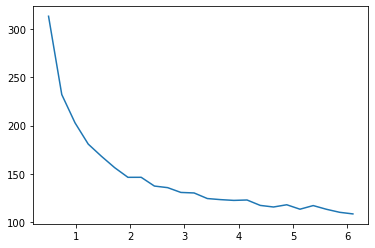

In [35]:
plt.plot(lambda_vals[0:24],cumerrlist)